## Correlation analysis:

In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import plotly.plotly as py
from plotly.graph_objs import *

##### Data loading:
We load accidents, temperature and wind datasets

In [145]:
df_accidents = pd.read_excel('../data/accidents/df_accidents.xlsx')
df_tmp = pd.read_excel('../data/df_tmp.xlsx')
df_wind = pd.read_excel('../data/df_wind.xlsx')

##### Data cleaning:
- some dates were replaced by NaT => retrieve dates for every sample
- drop duplicates when two avalanche reports were written the same day: we decided to keep only the first one

In [146]:
# remove NaT and replace with the right date
for i in range(0,7):
    index_NaT = df_tmp[df_tmp['date'].isnull()].index.values
    df_tmp.loc[index_NaT,'date'] = df_tmp.loc[index_NaT-1,'date'].values
    
df_tmp = df_tmp.drop_duplicates(subset=['date','region'], keep='first')#.set_index(['date','region'])

# remove NaT and replace with the right date
for i in range(0,5):
    index_NaT = df_wind[df_wind['date'].isnull()].index.values
    df_wind.loc[index_NaT,'date'] = df_wind.loc[index_NaT-1,'date'].values

df_wind = df_wind.drop_duplicates(subset=['date','region'], keep='first')#.set_index(['date','region'])

# select only accidents from 2002 until now
df_accidents = df_accidents[df_accidents.Date.apply(lambda d: d.year>2001)]

### Temperature and wind processing:

#### 1: Associate each accident with a location

In [147]:
loc = []
for ind,row in df_accidents.iterrows():
    if row.Longitude >8.8:
        loc.append('est')
    elif row.Longitude < 7.4:
        loc.append('ouest')
    elif row.Latitude > 46.8662:
        loc.append('nord')
    else:
        loc.append('sud')

df_accidents['region'] = loc    

#### 2: Associate each temperature with avalanche accidents data

In [148]:
# obtain accidents dates
#accident_dates = df_accidents.Date.tolist()

# keep temperature dates corresponding to accidents dates
temp_dates = df_tmp[df_tmp['date'].apply(lambda x: x in accident_dates)][['date','temperature']]
temp_dates = temp_dates.drop_duplicates(subset=['date'], keep='first')
df_accidents = df_accidents.rename(columns = {'Date':'date'})
df_accidents = pd.merge(df_accidents,temp_dates,how = 'outer', on = 'date')

mean_temp_gradient = 0.6
df_accidents.temperature = df_accidents.temperature + ((2000 - df_accidents.Elevation) / 100)*mean_temp_gradient
df_accidents.tail()

,date,Canton,Starting zone,Elevation,Aspect,Activity,Danger level,caught,buried,killed,Latitude,Longitude,region,temperature
270,2017-02-04,VS,Binn,2300,S,Backcountry touring,3.0,3,1.0,1,46.342085,8.207786,sud,-2.800
271,2017-02-05,VS,Ried-Brig,2205,NNE,Backcountry touring,3.0,1,NaN,1,46.283985,8.066959,sud,-5.230
272,2017-02-22,VS,Leukerbad,3590,S,Backcountry touring,2.0,1,1.0,1,46.423847,7.690221,sud,-7.540
273,2017-03-02,GR,Obersaxen Mundaun,2273,N,Off-piste skiing,3.0,2,1.0,1,46.708793,9.103164,est,-3.638
274,2017-09-21,BE,Grindelwald,3390,E,Backcountry touring,NaN,2,NaN,1,46.571666,8.008533,sud,NaN


In [149]:
coverage = (len(df_accidents[~np.isnan(df_accidents['temperature'])])/len(df_accidents))*100
print('Approximately %d percent of avalanche accidents are associated with their temperature' %coverage)

Approximately 81 percent of avalanche accidents are associated with their temperature


#### 3: Associate wind information with avalanche accidents data

In [150]:
wind_dates = df_wind[df_wind['date'].apply(lambda x: x in accident_dates)][['date','wind']]
wind_dates = wind_dates.drop_duplicates(subset=['date'],keep= 'first')
# Add wind to the accidents dataframe
df_accidents = pd.merge(df_accidents, wind_dates, how = 'outer', on = 'date')
df_accidents.tail()

,date,Canton,Starting zone,Elevation,Aspect,Activity,Danger level,caught,buried,killed,Latitude,Longitude,region,temperature,wind
270,2017-02-04,VS,Binn,2300,S,Backcountry touring,3.0,3,1.0,1,46.342085,8.207786,sud,-2.800,fort
271,2017-02-05,VS,Ried-Brig,2205,NNE,Backcountry touring,3.0,1,NaN,1,46.283985,8.066959,sud,-5.230,faible
272,2017-02-22,VS,Leukerbad,3590,S,Backcountry touring,2.0,1,1.0,1,46.423847,7.690221,sud,-7.540,fort
273,2017-03-02,GR,Obersaxen Mundaun,2273,N,Off-piste skiing,3.0,2,1.0,1,46.708793,9.103164,est,-3.638,faible
274,2017-09-21,BE,Grindelwald,3390,E,Backcountry touring,NaN,2,NaN,1,46.571666,8.008533,sud,NaN,NaN


In [151]:
coverage = (len(df_accidents[~pd.isnull(df_accidents['wind'])])/len(df_accidents))*100
print('Approximately %d percent of avalanche accidents are associated with their wind information' %coverage)

Approximately 65 percent of avalanche accidents are associated with their wind information


#### 4: Associate temperature evolution with avalanche accidents data 

For each avalanche accident, the temperature evolution one week before accidents is extracted.

In [153]:
# obtain accidents dates
temp_evol = []
date = []
df = df_tmp.drop_duplicates(subset=['date'], keep='first')

for index, row in df_tmp.iterrows():
    if row.date in accident_dates:
        dates = df_tmp.date[df_tmp.date.apply(lambda d: ((row.date-d).days <= 7) & ((row.date-d).days >= 0))].tolist()
        temp_evol.append(df.temperature[df.date.apply(lambda d: d in dates)].values)
        date.append(row.date)

temp_evol_df = pd.DataFrame({'date': date, 'temperature_evolution': temp_evol})
df_accidents = pd.merge(df_accidents,temp_evol_df, how = 'outer', on = 'date')

In [ ]:
df_accidents.to_excel('df_accidents_final.xlsx')

### Accidents analysis:

On the news or article: "Considering avalanche accidents, this is the deadliest year recorded in this canton !!!"

It could be interested to check if wether or not this is true.

In [312]:
df_accidents['year'] = df_accidents.date.apply(lambda d: d.year)

data = []
for canton in df_accidents['Canton'].unique():
    trace = Bar(
                x = df_accidents['year'].unique(),
                y = df_accidents[df_accidents['Canton']== canton].groupby(by='year')['date'].count(),
                name = canton
                )
    data.append(trace)

layout = Layout(title="Number of deadly avalanches accidents per year",
                xaxis=dict(title='Year'),
                yaxis=dict(title='Count'), 
                barmode = 'stack')
fig = Figure(data=data, layout = layout)
py.iplot(fig, filename='styled_bar_2')

Tendancy: small increase in avalanche accidents along time. This can be due to the fact that backcountry touring and offpiste skiing has become more popular, resulting in an increase in people being at risk to be caught in avalanche.

Another interesting feature is the month in which most accidents are likely to happen.

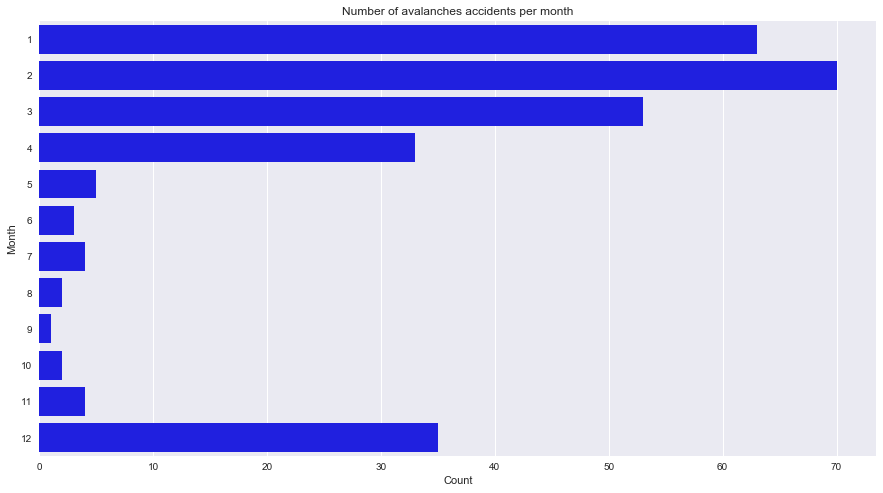

In [313]:
fig, ax = plt.subplots(1, sharey=True, figsize = (15,8));

df_accidents['month'] = df_accidents.date.apply(lambda d: d.month)
sns.countplot(y="month", data=df_accidents, color = 'blue', ax=ax); #order = df_accidents['Aspect'].value_counts().index);
ax.set_title('Number of avalanches accidents per month');
ax.set_xlabel('Count');
ax.set_ylabel('Month');

Most of accidents are happening in january and february

#### 1: Influence of elevation

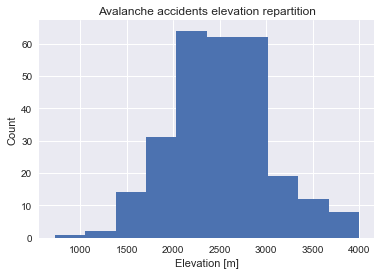

In [314]:
fig, ax = plt.subplots(1, sharey=True);

df_accidents.Elevation.hist(ax =ax)
ax.set_title('Avalanche accidents elevation repartition');
ax.set_xlabel('Elevation [m]');
ax.set_ylabel('Count');

#### 2: Aspect analysis

find aspects found more often

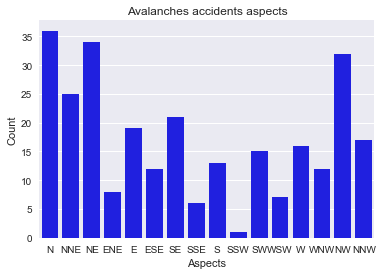

In [315]:
order = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']

fig, ax = plt.subplots(1, sharey=True);
sns.countplot(x="Aspect", data=df_accidents, ax=ax, color = 'blue', order = order);
ax.set_title('Avalanches accidents aspects');
ax.set_xlabel('Aspects');
ax.set_ylabel('Count');

correlate aspects with time of year (for example south aspect correlated with spring avalanches)

In [316]:
start_date = [9, 0, 3]
end_date = [12, 3, 6]
vec_season = ['start','middle','end']
ratio = ['start_ratio','middle_ratio','end_ratio']
name = ['start of season','middle of season','end of season']

def get_ratio (start_date, end_date):
        
    mask = [(date.month > start_date) & (date.month <= end_date) for date in df_accidents['date']]
    total = df_accidents[mask]['Aspect'].value_counts().sum()
    aspect_ratio = (df_accidents[mask]['Aspect'].value_counts() / total)*100
    aspect_ratio = aspect_ratio.reset_index()
    aspect_ratio.columns = ['Aspect','Ratio']
    
    return aspect_ratio

In [317]:
for season_time in range(0,3):
    aspect_ratio = get_ratio(start_date[season_time],end_date[season_time])
    exec("aspect_ratio%d = aspect_ratio" % (season_time))

aspect_ratio_final = aspect_ratio.merge(aspect_ratio0.merge(aspect_ratio1, on = 'Aspect', how = 'outer'), on = 'Aspect', how = 'outer')
aspect_ratio_final.columns = ['Aspect','end_ratio','start_ratio','middle_ratio']
aspect_ratio_final = aspect_ratio_final.set_index('Aspect').reindex(order) 

data = []
for r in range(3):
    trace = Bar(
                x = aspect_ratio_final.index.values,
                y = aspect_ratio_final[ratio[r]],
                name = name[r])
    data.append(trace)

layout = Layout(title="Frequency of avalanche accidents per aspect",
                xaxis=dict(title='Aspect'),
                yaxis=dict(title='Frequency'), 
                )
fig = Figure(data=data, layout = layout)
py.iplot(fig, filename='styled_bar')

We can see that considering south aspect accidents, most of them are at the end of the season

####  3: Activity analysis
Which activity is more dangerous ?

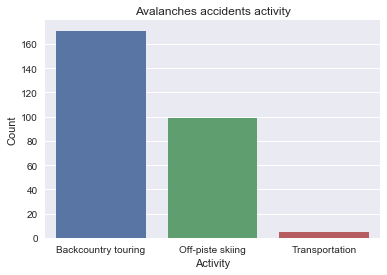

In [318]:
fig, ax = plt.subplots(1, sharey=True);

sns.countplot(x="Activity", data=df_accidents, ax=ax);
ax.set_title('Avalanches accidents activity');
ax.set_xlabel('Activity');
ax.set_ylabel('Count');

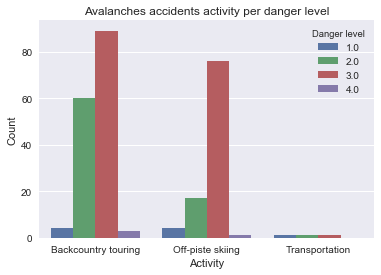

In [319]:
fig, ax = plt.subplots(1, sharey=True);

sns.countplot(x="Activity", hue = 'Danger level', data=df_accidents, ax=ax);
ax.set_title('Avalanches accidents activity per danger level');
ax.set_xlabel('Activity');
ax.set_ylabel('Count');

This graph shows the behaviour of skiiers depend on the activity they are doing.
We see that people doing backcountry touring take less risk than people doing off-piste skiing.

#### 4: Season time analysis:
Does most of accidents related to specific dates in year (for example beginning or end of ski season) ?

In [ ]:
fig, ax = plt.subplots(1);

sns.countplot(x="season", data=df_accidents, ax=ax);
ax.set_title('Avalanches accidents season');
ax.set_xlabel('Season time');
ax.set_ylabel('Count');

In [ ]:
fig, ax = plt.subplots(1, figsize = (10,5));

sns.countplot(x="season", hue = 'Danger level', data=df_accidents, ax=ax);
ax.set_title('Avalanches accidents season for each danger level');
ax.set_xlabel('Season');
ax.set_ylabel('Count');

#### 5: Mortality analysis:
mortality correlation with danger levels.
Mortality = number killed / number caught

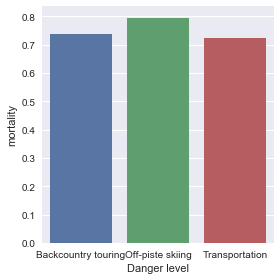

In [157]:
df_accidents['mortality'] = df_accidents['killed']/df_accidents['caught']
survival_rate = df_accidents.groupby(['Activity']).mean()[['killed','mortality']]
survival_rate = survival_rate.reset_index()
survival_rate.columns = ['Danger level','killed','mortality']
sns.factorplot(data = survival_rate, x= 'Danger level', y='mortality', kind="bar");

#### Correlation Coefficients:

In [322]:
labels = ['feature of interest', 'correlation with rank (pearson)','correlation with rank (spearman)','correlation with rank (kendall)']
interest_range_top = ['temperature','year','Elevation']
corr_danger = {'feature of interest':[], 
                'correlation with rank (pearson)':[],
                'correlation with rank (spearman)':[],
                'correlation with rank (kendall)':[]}
corr_type = ['pearson', 'spearman','kendall']

for ir in interest_range_top:
    corr_danger['feature of interest'].append(ir)
    for c in corr_type:
        corr_danger['correlation with rank ('+str(c)+')'].append(df_accidents['Danger level'].corr(df_accidents[ir], method=str(c)))

#putting the information into dataframes and making sure the order is right        
corr_danger_df = pd.DataFrame(corr_danger)
corr_danger_df = corr_danger_df[labels] 

In [323]:
corr_danger_df

,feature of interest,correlation with rank (pearson),correlation with rank (spearman),correlation with rank (kendall)
0,temperature,-0.117028,-0.083167,-0.065646
1,year,-0.041765,-0.046994,-0.039666
2,Elevation,-0.189390,-0.198926,-0.161006


### Propensity score:

From our previous analysis, the behaviour of skiiers seems to depend on the activity they are doing.
People doing backcountry touring seems to take less risk than people doing off-piste skiing.

But do draw valid conclusions, a propensity score matching is done.

In [334]:
from sklearn import linear_model 
# Groups: activity --> backcountry and hors piste
# Label: Danger level 
# Features --> Number of people in the group
#              Elevation 
#              Aspect
#              Temperature

# Create dic of aspect to get numerical values from aspect categories
aspect_dic = {}
for val, aspect in enumerate(order):
    aspect_dic[aspect]=val

In [337]:
# Keep only 2 activities
df = df_accidents[df_accidents.Activity != 'Transportation']
df = df[df.Activity != 'Building']
df = df.set_index(['date','Longitude','Latitude'])

# Create feature matrix
#features = df[['Activity','Aspect','Elevation','temperature','Danger level']]
features = df[['Activity','Aspect','Elevation','temperature','Danger level','survival_rate']]
features.Aspect = features.Aspect.replace(aspect_dic)
features['Activity'] = features['Activity'].apply(lambda x: 1 if x == 'Backcountry touring' else 0)
features = features.dropna()

# Create data matrix
data = features
#features = features.drop(['Danger level','Activity'], axis = 1)
features = features.drop(['survival_rate','Activity'], axis = 1)
features.head()

Aspect  Elevation  temperature  Danger level
date       Longitude Latitude                                               
2002-01-02 7.528077  46.546476    15.0       2360        -8.16           3.0
2002-01-03 9.815028  46.855337    12.0       2400        -4.40           3.0
2002-01-13 9.830075  46.836754     4.0       2240        -1.44           2.0
           7.818004  46.522445    13.0       2975        -5.85           1.0
2002-01-30 8.686867  46.696070    15.0       2910        -5.46           2.0

_Use logistic regression to estimate propensity scores for all points in the dataset._

In [338]:
model = linear_model.LogisticRegression()
model.fit(features, data.Activity)
pred = model.predict(features)

accuracy = sum(pred == data.Activity) / len(data.Activity)
print('accuracy: ', accuracy)

accuracy:  0.622727272727


The propensity scores are calculated and added to the dataframe

In [339]:
# Get propensity score
pscore = model.predict_proba(features)
data = data.assign(propensity_score = pscore[:,0])
data.head()

Activity  Aspect  Elevation  temperature  \
date       Longitude Latitude                                              
2002-01-02 7.528077  46.546476         1    15.0       2360        -8.16   
2002-01-03 9.815028  46.855337         0    12.0       2400        -4.40   
2002-01-13 9.830075  46.836754         0     4.0       2240        -1.44   
           7.818004  46.522445         1    13.0       2975        -5.85   
2002-01-30 8.686867  46.696070         1    15.0       2910        -5.46   

                                Danger level  survival_rate  propensity_score  
date       Longitude Latitude                                                  
2002-01-02 7.528077  46.546476           3.0       0.000000          0.353200  
2002-01-03 9.815028  46.855337           3.0       0.000000          0.354236  
2002-01-13 9.830075  46.836754           2.0       0.000000          0.356749  
           7.818004  46.522445           1.0       0.333333          0.180478  
2002-01-30 8.686867  46.696070           2.0       0.000000          0.221261

The propensity scores are used to match each data point from the backcountry skiing group with exactly one data point from the off_piste skiing group. To do that, we decided to use networkx package and work with DiGraph, which corresponds to directed graph with self loops.

In [340]:
import networkx as nx

G = nx.DiGraph()

# add a node for each sample
for i, row in data.iterrows():
    G.add_node(row.name, propensity=row['propensity_score'], Activity=row['Activity'])

# add an edge between treated control with propensity diff as weight
for n1, att1 in G.nodes(data=True):
    for n2, att2 in G.nodes(data=True):
        if att1['Activity'] == 1 and att2['Activity'] == 0:
            diff = abs(att1['propensity'] - att2['propensity'])
            G.add_edge(n1, n2, weight=1-diff)

matchings = nx.max_weight_matching(G)

Doublons are found for the matching.
So we split the matching output to get only unique matches (85 in total, as it should).

In [341]:
matchings
true_matching = {}

for treat,no_treat in matchings.items():
    if treat not in true_matching.values():
        true_matching[treat] = no_treat

The new matching is aplied to our dataset.

In [342]:
# Assign propensity score matching to the dataframe to keep only matched datapoints
data_offpiste = data.loc[[off_piste for backcountry, off_piste in true_matching.items()]]

# Assign propensity score matching to the dataframe to keep only matched datapoints
data_backcountry = data.loc[[backcountry for backcountry, off_piste in true_matching.items()]]

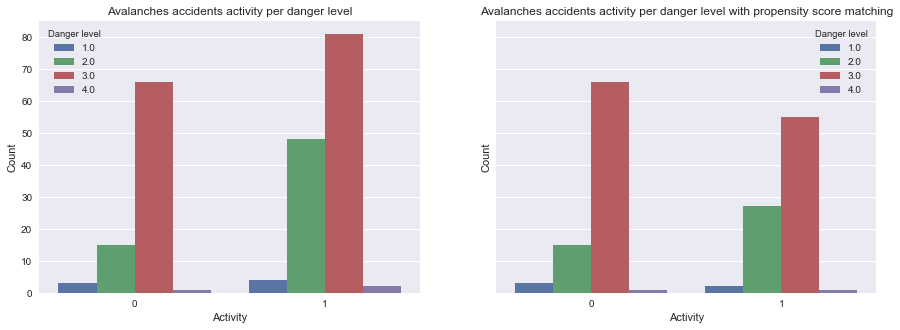

In [332]:
data_new = pd.concat([data_offpiste,data_backcountry])
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5));

sns.countplot(x="Activity", hue = 'Danger level', data=data, ax=ax[0]);
ax[0].set_title('Avalanches accidents activity per danger level');
ax[0].set_xlabel('Activity');
ax[0].set_ylabel('Count');

sns.countplot(x="Activity", hue = 'Danger level', data=data_new, ax=ax[1]);
ax[1].set_title('Avalanches accidents activity per danger level with propensity score matching');
ax[1].set_xlabel('Activity');
ax[1].set_ylabel('Count');

In [343]:
df_accidents['survival_rate'] = (df_accidents.caught - df_accidents.killed)/df_accidents.caught
data_new = pd.concat([data_offpiste,data_backcountry])
survival_rate = data_new.groupby(['Activity']).mean()[['survival_rate','propensity_score']]
survival_rate.head()

,survival_rate,propensity_score
Activity,,
0,0.204314,0.408170
1,0.246405,0.406706


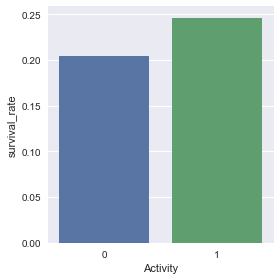

In [344]:
data_new = pd.concat([data_offpiste,data_backcountry])

survival_rate = data_new.groupby(['Activity']).mean()[['survival_rate','propensity_score']]
survival_rate = survival_rate.reset_index()
survival_rate.columns = ['Activity','survival_rate','propensity_score']
sns.factorplot(data = survival_rate, x= 'Activity', y='survival_rate', kind="bar");